Hello fellow kagglers! Lets check out tensorflow approach

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

# Utils

In [2]:
def get_best(history: dict, met='loss', best_min=True):
    val_met = f'val_{met}'
    bt = np.min(history[met]) if best_min else np.max(history[met])
    bv = None
    if val_met in history.keys():
        bv = np.min(history[val_met]) if best_min else np.max(history[val_met])
    return bv, bt

def plot_history(history: dict, k=0, met='loss', best_min=True):
    bbox = dict(
        boxstyle='round, pad=0.01',
        ec='w',
        fc='w',
        ls='-',
    )
    val_met = f'val_{met}'
    maxy = np.max(history[met][k:])
    miny = np.min(history[met][k:])
    if val_met in history.keys():
        maxy = np.max([np.max(history[met][k:]), np.max(history[val_met][k:])])
        miny = np.min([np.max(history[met][k:]), np.min(history[val_met][k:])])
    loss = history[met][k:]
    epochs = range(k + 1, len(loss) + 1 + k)
    xbin = len(epochs)
    if xbin > 50:
        xbin = xbin // 5
    elif xbin > 20:
        xbin = xbin // 2
    plt.figure(figsize=(12, 8))
    plt.locator_params(axis='y', nbins=10)
    plt.locator_params(axis='x', nbins=xbin)
    lr_key = 'lr'
    if lr_key in history.keys():
        lrd = []
        lr = history[lr_key][0]
        for i, l in enumerate(history[lr_key]):
            if (i > k) & (l < lr):
                lr = l
                lrd.append(i)
                plt.text(i, (maxy - miny) * 0.9 + miny, f'{lr:.2}', fontsize=10, bbox=bbox,
                         horizontalalignment='center')
        for i in lrd:
            plt.axvline(i, c='m')
    ep = (np.argmin(history[met]) if best_min else np.argmax(history[met])) + 1
    m = np.min(history[met]) if best_min else np.max(history[met])
    plt.plot(epochs, loss, label=f'Training {met}')
    if ep >= k:
        plt.scatter([ep], [m], c='tab:blue', s=75)
        plt.text(ep, m + (maxy - miny) * 0.02, f'{m:.4}', fontsize=15, bbox=bbox, horizontalalignment='center')
    if val_met in history.keys():
        ep = (np.argmin(history[val_met]) if best_min else np.argmax(history[val_met])) + 1
        m = np.min(history[val_met]) if best_min else np.max(history[val_met])
        val_loss = history[val_met][k:]
        plt.plot(epochs, val_loss, label=f'Validation {met}')
        if ep >= k:
            plt.scatter([ep], [m], c='tab:orange', s=75)
            plt.text(ep, m + (maxy - miny) * 0.02, f'{m:.4}', fontsize=15, bbox=bbox, horizontalalignment='center')
    plt.title(f'Training and validation {met}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{met}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Config

In [3]:
class conf:
    index = 'id'
    target = 'MedHouseVal'
    random = 2023
    batch_size = 64
    init_lr = 1e-3
    
    remove_out = False
    clip_out = False
    
    load_original = True
    min_max = False
    
    best_only = True
    
    is_interactive = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
#     verbose = 1 if is_interactive else 2
    verbose = False
np.random.seed(conf.random)

# Load data and simple EDA

In [4]:
train_full = pd.read_csv("/kaggle/input/playground-series-s3e1/train.csv", index_col=conf.index)
test_full = pd.read_csv("/kaggle/input/playground-series-s3e1/test.csv", index_col=conf.index)
train = train_full.copy()
if conf.load_original:
    print("Load external data...")
    original = fetch_california_housing()
    ext_df = pd.DataFrame(original['data'], columns=list(test_full.columns))
    ext_df[conf.target] = original['target']
    train = pd.concat([ext_df, train_full])
train.info()

Load external data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 57777 entries, 0 to 37136
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       57777 non-null  float64
 1   HouseAge     57777 non-null  float64
 2   AveRooms     57777 non-null  float64
 3   AveBedrms    57777 non-null  float64
 4   Population   57777 non-null  float64
 5   AveOccup     57777 non-null  float64
 6   Latitude     57777 non-null  float64
 7   Longitude    57777 non-null  float64
 8   MedHouseVal  57777 non-null  float64
dtypes: float64(9)
memory usage: 4.4 MB


In [5]:
train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000
mean,3.858046,26.979559,5.258104,1.074519,1576.720610,2.916770,35.592118,-119.559822,2.075753
std,1.838287,12.374508,1.771502,0.294086,1249.494223,6.575793,2.102374,1.984615,1.156927
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.588200,17.000000,4.381443,1.015306,882.000000,2.407625,33.930000,-121.800000,1.203000
50%,3.521400,26.000000,5.126761,1.052941,1316.000000,2.769231,34.210000,-118.460000,1.804000
75%,4.710900,36.000000,5.936031,1.091837,1815.000000,3.179673,37.700000,-118.020000,2.657000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


MedHouseVal    1.000000
MedInc         0.696527
AveRooms       0.236013
Latitude       0.126553
HouseAge       0.103085
Longitude      0.052846
AveBedrms      0.041327
Population     0.033360
AveOccup       0.026262
dtype: float64

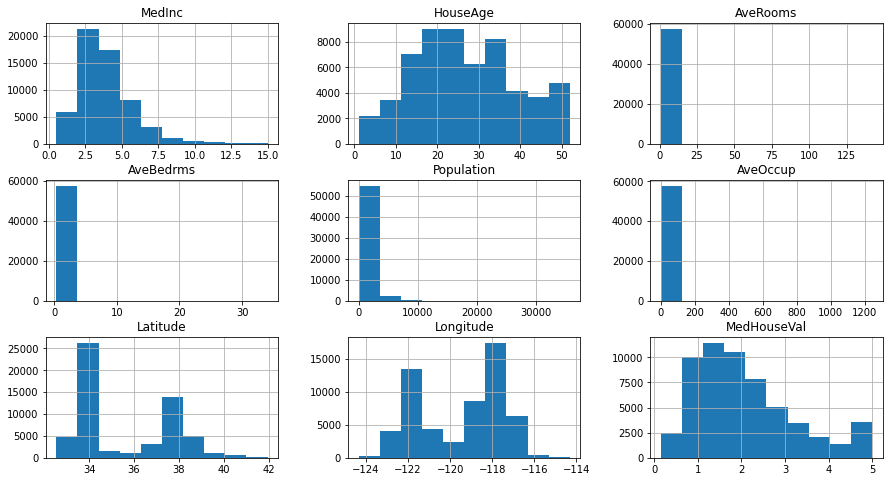

In [7]:
train.hist(figsize=(15, 8))
train.corrwith(train[conf.target]).abs().sort_values(ascending=False)

# Outliers work

In [8]:
def outliers(x):
    if conf.remove_out:
        x = x[x.MedInc < 10]
        x = x[x.AveRooms < 10]
        x = x[x.AveBedrms < 3]
        x = x[x.Population < 5000]
        x = x[x.AveOccup < 5]
    if conf.clip_out:
        x.MedInc = x.MedInc.clip(0, 7)
        x.AveRooms = x.AveRooms.clip(0, 7)
        x.AveBedrms = x.AveBedrms.clip(0, 2)
        x.Population = x.Population.clip(0, 3000)
        x.AveOccup = x.AveOccup.clip(0, 4)
    return x

In [9]:
train = outliers(train)  

Look at changes if we do something above

In [10]:
if conf.remove_out or conf.clip_out:
    train.hist(figsize=(15, 8))
    print(train.corrwith(x_train[conf.target]).abs().sort_values(ascending=False))

# Prepare data

In [11]:
pipe = sklearn.preprocessing.MinMaxScaler() if conf.min_max else sklearn.preprocessing.StandardScaler()
x_full = train.copy()
y_full = x_full.pop(conf.target).to_numpy()
x_full = pipe.fit_transform(x_full)
x_test = pipe.transform(test_full)

# Model

In [12]:
def get_model():
    l = 0.0001
    model = tf.keras.models.Sequential([
        layers.Dense(256, activation='relu', kernel_regularizer=reg.l2(l)),
        layers.Dense(128, activation='relu', kernel_regularizer=reg.l2(l)),
        layers.Dense(64, activation='relu', kernel_regularizer=reg.l2(l)),
        layers.Dense(1, activation='sigmoid'),
        layers.Rescaling(scale=5.0),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(conf.init_lr),
        loss="mse",
        metrics=tf.keras.metrics.RootMeanSquaredError(name="rmse")
    )
    return model

Callbacks

In [13]:
plat = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6, min_delta=0.0001, verbose = conf.verbose)
es = tf.keras.callbacks.EarlyStopping(patience=7, min_delta=0.0001, verbose = conf.verbose, restore_best_weights = True)

# Train

In [14]:
models = []
scores = []

for train_index, val_index in KFold(n_splits=10, random_state=conf.random, shuffle=True).split(x_full):
    x_train, x_val = x_full[train_index], x_full[val_index]
    y_train, y_val = y_full[train_index], y_full[val_index]
    
    model = get_model()
    h = model.fit(
        x_train, y_train,
        validation_data = (x_val, y_val),
        epochs = 100,
        batch_size = conf.batch_size,
        callbacks = [plat, es],
        verbose = conf.verbose,
    ).history    
    print(f"Best val rmse: {get_best(h, met='rmse')[0]:.4f}")
    
    s = mean_squared_error(y_val, model.predict(x_val), squared=False)
    scores.append(s)
    models.append((s, model))
print(f'mean scores:   {np.mean(scores):.4f}')

2023-01-09 15:09:14.223528: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-09 15:09:14.360278: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Best val rmse: 0.5519
Best val rmse: 0.5539
Best val rmse: 0.5438
Best val rmse: 0.5415
Best val rmse: 0.5828
Best val rmse: 0.5352
Best val rmse: 0.5580
Best val rmse: 0.5716
Best val rmse: 0.5414
Best val rmse: 0.5551
mean scores:   0.5536


# Plot history
Vertical purple line means learning rate decrease

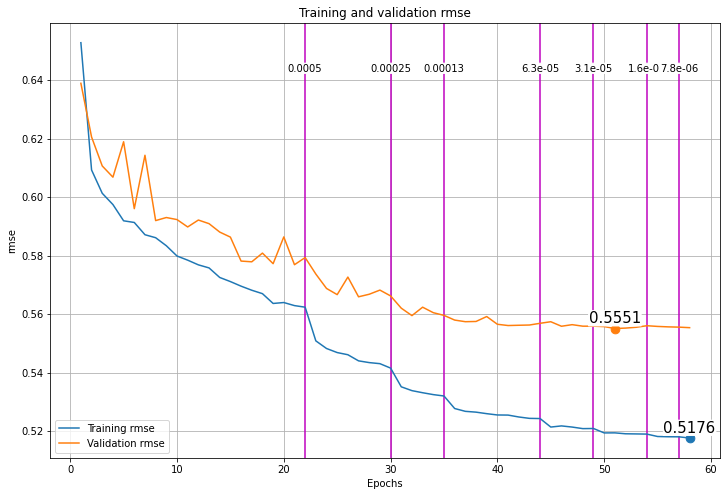

In [15]:
plot_history(h, met="rmse")

In [16]:
test_preds = []

bests = sorted(models)[:5] if conf.best_only else models

for s, m in bests:
    preds = m.predict(x_test)
    test_preds.append(preds)

In [17]:
test_preds = np.stack(test_preds).mean(0).reshape(-1)
test_preds

array([0.6249412, 1.104809 , 3.7111008, ..., 1.1482439, 3.7851639,
       3.06952  ], dtype=float32)

In [18]:
p = model.predict(x_test)
ss = pd.read_csv("/kaggle/input/playground-series-s3e1/sample_submission.csv", index_col=conf.index)
ss[conf.target] = test_preds
ss.to_csv("submission.csv")
ss.head()

,MedHouseVal
id,
37137,0.624941
37138,1.104809
37139,3.711101
37140,3.844899
37141,2.552615
